In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


# Preprocessing 

In [3]:
df.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [4]:
df.rename(columns={'Positive':'label', 'im getting on borderlands and i will murder you all ,': 'tweet'},inplace=True, )

In [5]:
df.head()

,2401,Borderlands,label,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
df = df[['label', 'tweet']]
df

,label,tweet
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [7]:
df.label.value_counts()

label
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

# Data Cleaning

In [8]:
df

,label,tweet
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [9]:
df.isna().sum()

label      0
tweet    686
dtype: int64

In [10]:
df[df.tweet.isna()==True]

,label,tweet
60,Neutral,NaN
552,Neutral,NaN
588,Neutral,NaN
744,Positive,NaN
1104,Positive,NaN
...,...,...
73971,Positive,NaN
73972,Positive,NaN
74420,Positive,NaN
74421,Positive,NaN


In [11]:
df.dropna(inplace=True)

In [12]:
df.isna().sum()

label    0
tweet    0
dtype: int64

# is there any duplicated data ? 

In [13]:
df.tweet.duplicated().sum()

4505

In [14]:
df[df.duplicated(subset='tweet')]

,label,tweet
19,Positive,that was the first borderlands session in a lo...
25,Negative,The biggest disappointment of my life came a y...
50,Neutral,Blaming Sight for Tardiness! A little bit of b...
63,Neutral,.. [
145,Negative,"""What a bitch!"""
...,...,...
74590,Neutral,you
74596,Positive,from
74618,Positive,This news about the Nvidia 3000 series is ligi...
74620,Positive,were


There are many values for the value 'you'

In [15]:
df[df.tweet == "you"]

,label,tweet
874,Negative,you
1084,Irrelevant,you
1330,Positive,you
2056,Positive,you
7156,Neutral,you
...,...,...
71278,Positive,you
71332,Negative,you
71752,Positive,you
73888,Neutral,you


In [16]:
df[df.tweet == 'were']

,label,tweet
6130,Positive,were
25228,Irrelevant,were
49936,Positive,were
74620,Positive,were


In [17]:
cleaned_df = df.drop_duplicates()

In [18]:
cleaned_df.shape

(69768, 2)

# ok now we move a little bit to the text

In [19]:
nlp = spacy.load("en_core_web_sm")

In [20]:
def preprocess_data(text):
    tokens = nlp(text)
    filtered_token = []
    for token in tokens:
        # is stop is a set of commonly used words in a langauage like is and the
        if token.is_punct or token.is_stop:
            continue
        filtered_token.append(token.lemma_)
    return " ".join(filtered_token)

In [21]:
cleaned_df['preprocessed_data'] = cleaned_df.tweet.apply(preprocess_data)

/tmp/ipykernel_34/3762362689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['preprocessed_data'] = cleaned_df.tweet.apply(preprocess_data)


# i will do the same for the validation dataset cleaning and processing

In [80]:
test_df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv")
test_df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [81]:
test_df.rename(columns={'Irrelevant':'label', 'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'tweet'},inplace=True, )
test_df = test_df[['label', 'tweet']]
test_df

,label,tweet
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [82]:
test_df.isna().sum()

label    0
tweet    0
dtype: int64

In [84]:
print(test_df.duplicated().any())
test_df[test_df.tweet == "Wow"]

True


,label,tweet
217,Positive,Wow
962,Positive,Wow


In [85]:
test_df = test_df.drop_duplicates()
test_df['preprocessed_tweet'] = test_df.tweet.apply(preprocess_data)

/tmp/ipykernel_34/2184113880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['preprocessed_tweet'] = test_df.tweet.apply(preprocess_data)


# encoding the label to 0 - 3 classes

In [86]:
encoder = LabelEncoder()
cleaned_df.label = encoder.fit_transform(cleaned_df.label)
test_df.label = encoder.fit_transform(test_df.label)

/tmp/ipykernel_34/365067223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.label = encoder.fit_transform(cleaned_df.label)
/tmp/ipykernel_34/365067223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.label = encoder.fit_transform(test_df.label)


In [25]:
encoder.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

# extracting X and Y

In [87]:
X = cleaned_df["preprocessed_data"] 
y = cleaned_df.label
X_test = test_df.preprocessed_tweet 
y_test = test_df.label

# Splitting into train and test data 

In [28]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# TF-IDF stands for Term Frequency-Inverse Document Frequency.

In [88]:
v = TfidfVectorizer()
X_train_normalized = v.fit_transform(x_train)
X_valid_normalized = v.transform(x_valid)
X_test_normalized = v.transform(X_test)

# training models

In [30]:
rf_clf = RandomForestClassifier(n_estimators=60)
rf_clf.fit(X_train_normalized, y_train)

RandomForestClassifier(n_estimators=60)

In [33]:
rf_clf.score(X_train_normalized, y_train)

0.9864370946357545

# using the validation set now 

In [34]:
y_pred = rf_clf.predict(X_valid_normalized)

In [36]:
print(accuracy_score(y_valid, y_pred))

0.9189479719076967


In [38]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      2457
           1       0.92      0.94      0.93      4248
           2       0.94      0.90      0.92      3422
           3       0.88      0.94      0.91      3827

    accuracy                           0.92     13954
   macro avg       0.92      0.91      0.92     13954
weighted avg       0.92      0.92      0.92     13954



In [43]:

cm = confusion_matrix(y_valid, y_pred)

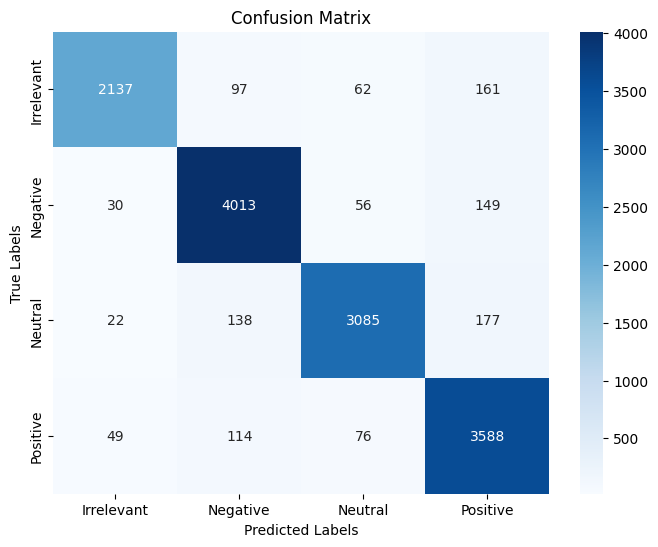

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# testing now 

In [74]:
joblib_file = "tweets_rf_clf_Model.pkl"  
joblib.dump(rf_clf, joblib_file)

['tweets_rf_clf_Model.pkl']

In [ ]:
tweet_clf_model = joblib.load(joblib_file)

In [75]:
y_pred = tweet_clf_model.predict(X_test_normalized)

In [91]:
print(accuracy_score(y_test, y_pred))

0.9468937875751503


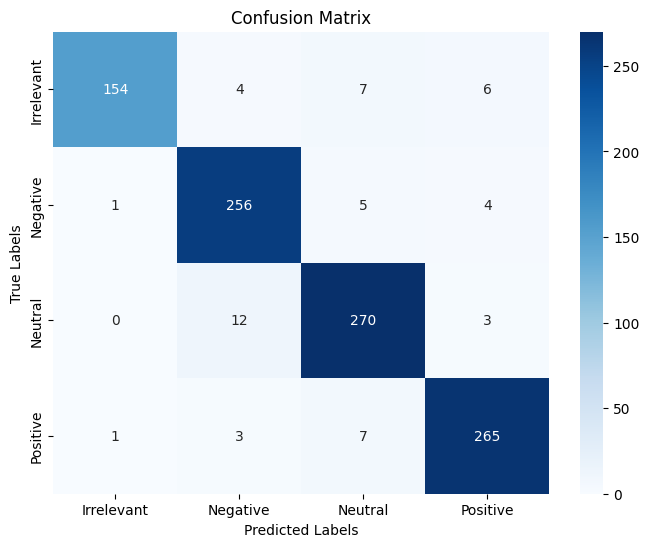

In [92]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Rana (2024)